In [1]:
# import the necessary packages
from torch.utils.data import Dataset
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import cv2
import time
from torchvision import transforms
from torch import nn

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Assuming 'base_dir' is the path to the directory containing your four folders
base_dir = '/content/drive/MyDrive/MLProjectData/competition_data'
classes = ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

# Create a list to hold file paths and labels
image_paths = []
image_labels = []

# Map each class name to an integer label
label_dict = {class_name: index for index, class_name in enumerate(classes)}

# Go through each folder and add file paths and labels to the list
for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)
    for file_name in os.listdir(class_dir):
        if file_name.endswith('.jpg'):
            image_paths.append(os.path.join(class_dir, file_name))
            image_labels.append(label_dict[class_name])


In [4]:
len(image_paths)
type(image_paths)

list

In [5]:
len(image_labels)
type(image_labels)

list

In [6]:
trial_image = cv2.imread(image_paths[5])

In [7]:
trial_image.shape

(256, 256, 3)

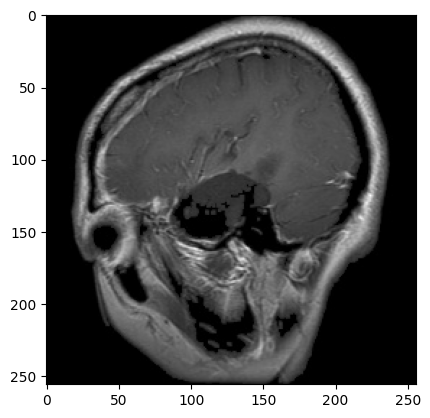

In [8]:
plt.imshow(trial_image)

In [9]:
class Configuration:

    TEST_SPLIT = 0.1

    device = "cuda" if torch.cuda.is_available() else "cpu"

    PIN_MEMORY = True if device == "cuda" else False

    NUM_CHANNELS = 3  # Number of channels in the image
    NUM_CLASSES = 4   # Number of classes for classification
    NUM_LEVELS = 3    # Depth of the UNet


    INIT_LR = 0.0001  # Initial learning rate
    NUM_EPOCHS = 40   # Number of epochs
    BATCH_SIZE = 32   # Number of samples in a batch

    INPUT_IMAGE_WIDTH = 256
    INPUT_IMAGE_HEIGHT = 256

    THRESHOLD = 0.5

configuration = Configuration()

In [10]:
class Segmentation(Dataset):
	def __init__(self, image_paths, labels, transforms):

		self.image_paths = image_paths
		self.labels = image_labels
		self.transforms = transforms

	def __len__(self):
		return len(self.image_paths)

	def __getitem__(self, idx):
		imagePath = self.image_paths[idx]

		image = cv2.imread(imagePath)
		# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		label = self.labels[idx]

		if self.transforms is not None:
			# apply the transformations to image
			image = self.transforms(image)

		return (image, label)

In [11]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)

	def forward(self, x):
		x = self.conv1(x)
		x = self.relu(x)
		x = self.conv2(x)
		return x
		# return self.conv2(self.relu(self.conv1(x)))

In [12]:
class encoderBlock(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()

		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)

	def forward(self, x):

		blockOutputs = []


		for block in self.encBlocks:

			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)


		return blockOutputs

In [13]:
class decoderBlock(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])

	def forward(self, x, encFeatures):

		for i in range(len(self.channels) - 1):

			x = self.upconvs[i](x)


			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)


		return x

	def crop(self, encFeatures, x):

		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)


		return encFeatures

In [14]:
class UNet(Module):
  def __init__(self, encChannels = (3, 16, 32, 64), decChannels = (64, 32, 16), nbClasses = 4, retainDim = True, outSize=(configuration.INPUT_IMAGE_HEIGHT,  configuration.INPUT_IMAGE_WIDTH)):
    super().__init__()

    self.encoder = encoderBlock(encChannels)
    self.decoder = decoderBlock(decChannels)


    self.head = self.head = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),  # Global Average Pooling
        nn.Flatten(),  # Flatten the output
        nn.Linear(decChannels[-1], nbClasses))
    self.retainDim = retainDim
    self.outSize = outSize

  def forward(self, x):
    encFeatures = self.encoder(x)
    decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])


    class_scores = self.head(decFeatures)

    return class_scores





### Define the data pipeline

In [15]:
split = train_test_split(image_paths, image_labels,
	test_size=configuration.TEST_SPLIT, random_state=42)

In [16]:
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:]

In [17]:
trainDS = Segmentation(image_paths=trainImages, labels=trainLabels,
	transforms=transforms)

In [18]:
len(trainDS)

2227

In [19]:
from torchvision import transforms
from torch import nn


# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(image_paths, image_labels,
	test_size=Configuration.TEST_SPLIT, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:]


# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((Configuration.INPUT_IMAGE_HEIGHT,
		Configuration.INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])

# create the train and test datasets
trainDS = Segmentation(image_paths=trainImages, labels=trainLabels,
	transforms=transforms)
testDS = Segmentation(image_paths=testImages, labels=testLabels,
    transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=Configuration.BATCH_SIZE, pin_memory=Configuration.PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=Configuration.BATCH_SIZE, pin_memory=Configuration.PIN_MEMORY,
	num_workers=os.cpu_count())

[INFO] found 2227 examples in the training set...
[INFO] found 248 examples in the test set...


### Train the model

Training starts here for the network ...


  2%|▎         | 1/40 [05:59<3:53:49, 359.73s/it]

[INFO] EPOCH: 1/40
Train loss: 1.399850, Test loss: 1.2609
Train accuracy: 0.2537, Test accuracy: 1.0000


  5%|▌         | 2/40 [06:13<1:38:51, 156.09s/it]

[INFO] EPOCH: 2/40
Train loss: 1.362047, Test loss: 1.2530
Train accuracy: 0.3134, Test accuracy: 0.9556


  8%|▊         | 3/40 [06:27<56:12, 91.16s/it]   

[INFO] EPOCH: 3/40
Train loss: 1.359649, Test loss: 1.3160
Train accuracy: 0.3202, Test accuracy: 0.2581


 10%|█         | 4/40 [06:41<36:24, 60.67s/it]

[INFO] EPOCH: 4/40
Train loss: 1.358453, Test loss: 1.3027
Train accuracy: 0.3220, Test accuracy: 0.0000


 12%|█▎        | 5/40 [06:55<25:38, 43.96s/it]

[INFO] EPOCH: 5/40
Train loss: 1.359722, Test loss: 1.3377
Train accuracy: 0.3188, Test accuracy: 0.0000


 15%|█▌        | 6/40 [07:09<19:08, 33.77s/it]

[INFO] EPOCH: 6/40
Train loss: 1.359520, Test loss: 1.3132
Train accuracy: 0.3260, Test accuracy: 0.0000


 18%|█▊        | 7/40 [07:23<15:03, 27.39s/it]

[INFO] EPOCH: 7/40
Train loss: 1.358315, Test loss: 1.2644
Train accuracy: 0.3251, Test accuracy: 0.0000


 20%|██        | 8/40 [07:37<12:19, 23.12s/it]

[INFO] EPOCH: 8/40
Train loss: 1.358686, Test loss: 1.3262
Train accuracy: 0.3278, Test accuracy: 0.0000


 22%|██▎       | 9/40 [07:51<10:26, 20.21s/it]

[INFO] EPOCH: 9/40
Train loss: 1.358620, Test loss: 1.3183
Train accuracy: 0.3179, Test accuracy: 0.0000


 25%|██▌       | 10/40 [08:05<09:10, 18.36s/it]

[INFO] EPOCH: 10/40
Train loss: 1.357378, Test loss: 1.2612
Train accuracy: 0.3260, Test accuracy: 0.0000


 28%|██▊       | 11/40 [08:19<08:11, 16.96s/it]

[INFO] EPOCH: 11/40
Train loss: 1.359005, Test loss: 1.3300
Train accuracy: 0.3309, Test accuracy: 0.9919


 30%|███       | 12/40 [08:33<07:29, 16.06s/it]

[INFO] EPOCH: 12/40
Train loss: 1.359692, Test loss: 1.2743
Train accuracy: 0.3256, Test accuracy: 0.0000


 32%|███▎      | 13/40 [08:47<06:55, 15.40s/it]

[INFO] EPOCH: 13/40
Train loss: 1.359146, Test loss: 1.2558
Train accuracy: 0.3175, Test accuracy: 0.0000


 35%|███▌      | 14/40 [09:01<06:28, 14.96s/it]

[INFO] EPOCH: 14/40
Train loss: 1.358264, Test loss: 1.2747
Train accuracy: 0.3296, Test accuracy: 0.8831


 38%|███▊      | 15/40 [09:15<06:06, 14.67s/it]

[INFO] EPOCH: 15/40
Train loss: 1.358541, Test loss: 1.2816
Train accuracy: 0.3179, Test accuracy: 0.0000


 40%|████      | 16/40 [09:29<05:47, 14.49s/it]

[INFO] EPOCH: 16/40
Train loss: 1.357260, Test loss: 1.3538
Train accuracy: 0.3282, Test accuracy: 0.9194


 42%|████▎     | 17/40 [09:43<05:30, 14.37s/it]

[INFO] EPOCH: 17/40
Train loss: 1.358555, Test loss: 1.2715
Train accuracy: 0.3125, Test accuracy: 1.0000


 45%|████▌     | 18/40 [09:57<05:13, 14.25s/it]

[INFO] EPOCH: 18/40
Train loss: 1.357753, Test loss: 1.3365
Train accuracy: 0.3260, Test accuracy: 1.0000


 48%|████▊     | 19/40 [10:11<04:56, 14.14s/it]

[INFO] EPOCH: 19/40
Train loss: 1.358528, Test loss: 1.3077
Train accuracy: 0.3170, Test accuracy: 0.0000


 50%|█████     | 20/40 [10:25<04:41, 14.06s/it]

[INFO] EPOCH: 20/40
Train loss: 1.357146, Test loss: 1.2744
Train accuracy: 0.3273, Test accuracy: 0.0000


 52%|█████▎    | 21/40 [10:39<04:27, 14.06s/it]

[INFO] EPOCH: 21/40
Train loss: 1.359604, Test loss: 1.2843
Train accuracy: 0.3206, Test accuracy: 0.0000


 55%|█████▌    | 22/40 [10:53<04:12, 14.02s/it]

[INFO] EPOCH: 22/40
Train loss: 1.357688, Test loss: 1.2922
Train accuracy: 0.3296, Test accuracy: 0.7903


 57%|█████▊    | 23/40 [11:07<03:59, 14.08s/it]

[INFO] EPOCH: 23/40
Train loss: 1.357061, Test loss: 1.2840
Train accuracy: 0.3256, Test accuracy: 0.0524


 60%|██████    | 24/40 [11:21<03:44, 14.06s/it]

[INFO] EPOCH: 24/40
Train loss: 1.358529, Test loss: 1.2401
Train accuracy: 0.3121, Test accuracy: 0.9919


 62%|██████▎   | 25/40 [11:35<03:31, 14.07s/it]

[INFO] EPOCH: 25/40
Train loss: 1.357212, Test loss: 1.2936
Train accuracy: 0.3170, Test accuracy: 0.1008


 65%|██████▌   | 26/40 [11:49<03:16, 14.03s/it]

[INFO] EPOCH: 26/40
Train loss: 1.358905, Test loss: 1.2787
Train accuracy: 0.3170, Test accuracy: 0.0202


 68%|██████▊   | 27/40 [12:03<03:02, 14.01s/it]

[INFO] EPOCH: 27/40
Train loss: 1.358023, Test loss: 1.2783
Train accuracy: 0.3215, Test accuracy: 0.9032


 70%|███████   | 28/40 [12:17<02:48, 14.02s/it]

[INFO] EPOCH: 28/40
Train loss: 1.358106, Test loss: 1.2829
Train accuracy: 0.3273, Test accuracy: 0.0000


 72%|███████▎  | 29/40 [12:31<02:33, 13.99s/it]

[INFO] EPOCH: 29/40
Train loss: 1.357068, Test loss: 1.2849
Train accuracy: 0.3273, Test accuracy: 0.0000


 75%|███████▌  | 30/40 [12:45<02:19, 13.96s/it]

[INFO] EPOCH: 30/40
Train loss: 1.357469, Test loss: 1.3030
Train accuracy: 0.3202, Test accuracy: 0.0000


 78%|███████▊  | 31/40 [12:59<02:06, 14.01s/it]

[INFO] EPOCH: 31/40
Train loss: 1.357252, Test loss: 1.2927
Train accuracy: 0.3278, Test accuracy: 0.0000


 80%|████████  | 32/40 [13:13<01:52, 14.06s/it]

[INFO] EPOCH: 32/40
Train loss: 1.356926, Test loss: 1.2778
Train accuracy: 0.3278, Test accuracy: 0.0000


 82%|████████▎ | 33/40 [13:27<01:38, 14.00s/it]

[INFO] EPOCH: 33/40
Train loss: 1.357447, Test loss: 1.3271
Train accuracy: 0.3269, Test accuracy: 0.2944


 85%|████████▌ | 34/40 [13:41<01:23, 14.00s/it]

[INFO] EPOCH: 34/40
Train loss: 1.356618, Test loss: 1.2659
Train accuracy: 0.3256, Test accuracy: 0.0000


 88%|████████▊ | 35/40 [13:55<01:10, 14.05s/it]

[INFO] EPOCH: 35/40
Train loss: 1.357440, Test loss: 1.2964
Train accuracy: 0.3260, Test accuracy: 0.5323


 90%|█████████ | 36/40 [14:09<00:56, 14.11s/it]

[INFO] EPOCH: 36/40
Train loss: 1.358282, Test loss: 1.2889
Train accuracy: 0.3202, Test accuracy: 0.5242


 92%|█████████▎| 37/40 [14:23<00:41, 13.97s/it]

[INFO] EPOCH: 37/40
Train loss: 1.357887, Test loss: 1.3144
Train accuracy: 0.3148, Test accuracy: 0.2702


 95%|█████████▌| 38/40 [14:37<00:28, 14.08s/it]

[INFO] EPOCH: 38/40
Train loss: 1.359192, Test loss: 1.3130
Train accuracy: 0.3273, Test accuracy: 0.8629


 98%|█████████▊| 39/40 [14:51<00:14, 14.06s/it]

[INFO] EPOCH: 39/40
Train loss: 1.358329, Test loss: 1.3116
Train accuracy: 0.3305, Test accuracy: 0.4879


100%|██████████| 40/40 [15:05<00:00, 22.64s/it]

[INFO] EPOCH: 40/40
Train loss: 1.358468, Test loss: 1.2951
Train accuracy: 0.3094, Test accuracy: 0.0081
Time taken to train the model: 905.72s


RuntimeError: ignored

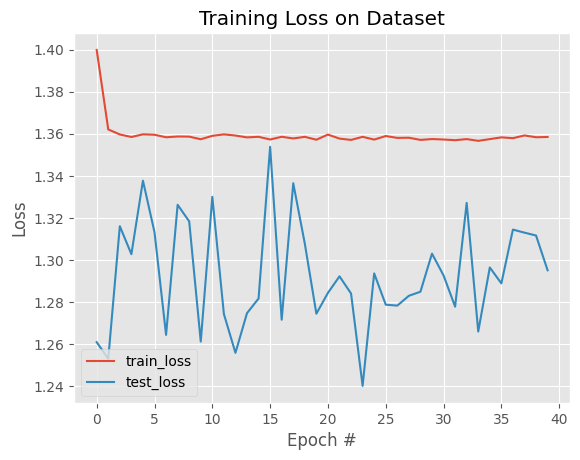

In [30]:
# initialize our UNet model
unet = UNet().to(configuration.device)

lossFunc = nn.CrossEntropyLoss()    # CrossEntropy as it is a multi class classificiation
opt = Adam(unet.parameters(), lr=configuration.INIT_LR)


trainSteps = len(trainDS) // configuration.BATCH_SIZE
testSteps = len(testDS) // configuration.BATCH_SIZE

H = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}


print("Training starts here for the network ...")
startTime = time.time()
for e in tqdm(range(configuration.NUM_EPOCHS)):

	unet.train()


	totalTrainLoss = 0
	totalTestLoss = 0
	trainCorrect = 0
	trainTotal = 0
	testCorrect = 0
	testTotal = 0


	for (i, (x, y)) in enumerate(trainLoader):

		(x, y) = (x.to(configuration.device), y.to(configuration.device))

		pred = unet(x)
		loss = lossFunc(pred, y.long())


		_, predictions = torch.max(pred, 1)
		trainCorrect += (predictions == y).sum().item()
		trainTotal += y.size(0)


		opt.zero_grad()
		loss.backward()
		opt.step()

		totalTrainLoss += loss

	trainAcc = trainCorrect / trainTotal
	H["train_acc"].append(trainAcc)

	with torch.no_grad():

		unet.eval()

		for (x, y) in testLoader:
			(x, y) = (x.to(configuration.device), y.to(configuration.device))

			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)

			_, predictions = torch.max(pred, 1)
			testCorrect += (predictions == y).sum().item()
			testTotal += y.size(0)

	testAcc = testCorrect / testTotal
	H["test_acc"].append(testAcc)

	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps


	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())


	print("[INFO] EPOCH: {}/{}".format(e + 1, Configuration.NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))

	print(f"Train accuracy: {trainAcc:.4f}, Test accuracy: {testAcc:.4f}")

endTime = time.time()
print("Time taken to train the model: {:.2f}s".format(
	endTime - startTime))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

model_save_path = '/content/drive/MyDrive/MLProjectData/unet_model.pth'
torch.save(unet.state_dict(), model_save_path)

### Predict using the trained model

In [20]:
def make_predictions(model, image_path, classLabels):
    # set model to evaluation mode
    model.eval()

    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (configuration.INPUT_IMAGE_WIDTH, configuration.INPUT_IMAGE_HEIGHT))
        image = image.astype("float32") / 255.0

        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(Configuration.device)

        # make the prediction and retrieve the index of the highest
        # score to find the predicted class label
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        predictedClass = preds.cpu().numpy()[0]

    # return the original image and the predicted class label
    return image, classLabels[predictedClass]


In [21]:
# Assuming 'base_dir' is the path to the directory containing your four folders
base_dir_2 = '/content/drive/MyDrive/MLProjectData/kaggle_solutionSet'
classes = ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

# Create a list to hold file paths and labels
kaggle_image_paths = []

for file_name in os.listdir(base_dir_2):
    if file_name.endswith('.jpg'):
        kaggle_image_paths.append(os.path.join(base_dir_2, file_name))




In [22]:
len(kaggle_image_paths)

621

In [36]:
import pandas as pd

# Assuming `testImages` is a list of file paths in your test set
# and `classLabels` is a list or dict mapping class indices to class names

# Initialize a list to store image names and predicted class names
predictions = []

# Loop over the test images
for imagePath in kaggle_image_paths:
    # Extract the image file name
    imageFileName = imagePath.split(os.path.sep)[-1]

    # Make a prediction using the model
    _, predictedClass = make_predictions(unet, imagePath, classes)

    # Store the result
    predictions.append([imageFileName, predictedClass])

# Convert the predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['ID', 'prediction'])

# Save the predictions to a CSV file
predictions_csv_path = '/content/drive/MyDrive/MLProjectData/predictions.csv'
predictions_df.to_csv(predictions_csv_path, index=False)

print(f"Predictions saved to {predictions_csv_path}")


Predictions saved to /content/drive/MyDrive/MLProjectData/predictions.csv


UNet with image augmentation

In [23]:
from torchvision import transforms
from torch import nn


# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(image_paths, image_labels,
	test_size=Configuration.TEST_SPLIT, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:]


# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((Configuration.INPUT_IMAGE_HEIGHT,
		Configuration.INPUT_IMAGE_WIDTH)),
	transforms.RandomRotation(degrees=10),
	transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
	transforms.ToTensor()])

# create the train and test datasets
trainDS = Segmentation(image_paths=trainImages, labels=trainLabels,
	transforms=transforms)
testDS = Segmentation(image_paths=testImages, labels=testLabels,
    transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=Configuration.BATCH_SIZE, pin_memory=Configuration.PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=Configuration.BATCH_SIZE, pin_memory=Configuration.PIN_MEMORY,
	num_workers=os.cpu_count())

[INFO] found 2227 examples in the training set...
[INFO] found 248 examples in the test set...


Training starts here for the network ...


  2%|▎         | 1/40 [00:15<09:55, 15.27s/it]

[INFO] EPOCH: 1/40
Train loss: 1.404332, Test loss: 1.0969
Train accuracy: 0.2286, Test accuracy: 1.0000
New best model found at epoch 1 with test loss 1.0969


  5%|▌         | 2/40 [00:30<09:41, 15.29s/it]

[INFO] EPOCH: 2/40
Train loss: 1.359367, Test loss: 1.3528
Train accuracy: 0.3121, Test accuracy: 0.0000


  8%|▊         | 3/40 [00:45<09:13, 14.96s/it]

[INFO] EPOCH: 3/40
Train loss: 1.361324, Test loss: 1.3182
Train accuracy: 0.3206, Test accuracy: 0.0000


 10%|█         | 4/40 [00:59<08:54, 14.86s/it]

[INFO] EPOCH: 4/40
Train loss: 1.358382, Test loss: 1.3473
Train accuracy: 0.3247, Test accuracy: 0.0000


 12%|█▎        | 5/40 [01:16<09:00, 15.44s/it]

[INFO] EPOCH: 5/40
Train loss: 1.358904, Test loss: 1.3061
Train accuracy: 0.3278, Test accuracy: 0.0000


 15%|█▌        | 6/40 [01:30<08:36, 15.18s/it]

[INFO] EPOCH: 6/40
Train loss: 1.358596, Test loss: 1.3315
Train accuracy: 0.3179, Test accuracy: 0.0000


 18%|█▊        | 7/40 [01:46<08:21, 15.19s/it]

[INFO] EPOCH: 7/40
Train loss: 1.360071, Test loss: 1.2518
Train accuracy: 0.3022, Test accuracy: 0.9476


 20%|██        | 8/40 [02:01<08:05, 15.17s/it]

[INFO] EPOCH: 8/40
Train loss: 1.358444, Test loss: 1.2758
Train accuracy: 0.3260, Test accuracy: 0.0000


 22%|██▎       | 9/40 [02:16<07:51, 15.21s/it]

[INFO] EPOCH: 9/40
Train loss: 1.359328, Test loss: 1.3363
Train accuracy: 0.3224, Test accuracy: 0.0000


 25%|██▌       | 10/40 [02:31<07:35, 15.17s/it]

[INFO] EPOCH: 10/40
Train loss: 1.357852, Test loss: 1.3518
Train accuracy: 0.3238, Test accuracy: 0.0000


 28%|██▊       | 11/40 [02:46<07:16, 15.05s/it]

[INFO] EPOCH: 11/40
Train loss: 1.358698, Test loss: 1.3495
Train accuracy: 0.3381, Test accuracy: 0.0000


 30%|███       | 12/40 [03:00<06:53, 14.77s/it]

[INFO] EPOCH: 12/40
Train loss: 1.359049, Test loss: 1.2892
Train accuracy: 0.3278, Test accuracy: 0.0040


 32%|███▎      | 13/40 [03:15<06:35, 14.67s/it]

[INFO] EPOCH: 13/40
Train loss: 1.357802, Test loss: 1.2477
Train accuracy: 0.3188, Test accuracy: 0.7177


 35%|███▌      | 14/40 [03:30<06:25, 14.82s/it]

[INFO] EPOCH: 14/40
Train loss: 1.358748, Test loss: 1.2906
Train accuracy: 0.3193, Test accuracy: 0.0040


 38%|███▊      | 15/40 [03:45<06:13, 14.93s/it]

[INFO] EPOCH: 15/40
Train loss: 1.358698, Test loss: 1.3326
Train accuracy: 0.3251, Test accuracy: 0.0000


 40%|████      | 16/40 [04:00<06:02, 15.09s/it]

[INFO] EPOCH: 16/40
Train loss: 1.358207, Test loss: 1.3140
Train accuracy: 0.3193, Test accuracy: 0.0121


 42%|████▎     | 17/40 [04:15<05:46, 15.05s/it]

[INFO] EPOCH: 17/40
Train loss: 1.358304, Test loss: 1.2917
Train accuracy: 0.3251, Test accuracy: 0.0000


 45%|████▌     | 18/40 [04:30<05:31, 15.05s/it]

[INFO] EPOCH: 18/40
Train loss: 1.357980, Test loss: 1.2310
Train accuracy: 0.3233, Test accuracy: 0.9718


 48%|████▊     | 19/40 [04:45<05:11, 14.81s/it]

[INFO] EPOCH: 19/40
Train loss: 1.358673, Test loss: 1.3187
Train accuracy: 0.3211, Test accuracy: 0.0000


 50%|█████     | 20/40 [04:59<04:55, 14.78s/it]

[INFO] EPOCH: 20/40
Train loss: 1.358192, Test loss: 1.2645
Train accuracy: 0.3314, Test accuracy: 0.3185


 52%|█████▎    | 21/40 [05:14<04:40, 14.76s/it]

[INFO] EPOCH: 21/40
Train loss: 1.358448, Test loss: 1.3194
Train accuracy: 0.3139, Test accuracy: 0.0000


 55%|█████▌    | 22/40 [05:30<04:29, 14.97s/it]

[INFO] EPOCH: 22/40
Train loss: 1.357808, Test loss: 1.3374
Train accuracy: 0.3318, Test accuracy: 0.0000


 57%|█████▊    | 23/40 [05:45<04:15, 15.05s/it]

[INFO] EPOCH: 23/40
Train loss: 1.358210, Test loss: 1.2588
Train accuracy: 0.3179, Test accuracy: 0.1290


 60%|██████    | 24/40 [06:00<04:00, 15.00s/it]

[INFO] EPOCH: 24/40
Train loss: 1.358519, Test loss: 1.3480
Train accuracy: 0.3260, Test accuracy: 0.0000


 62%|██████▎   | 25/40 [06:14<03:44, 14.96s/it]

[INFO] EPOCH: 25/40
Train loss: 1.358484, Test loss: 1.2790
Train accuracy: 0.3282, Test accuracy: 0.8790


 65%|██████▌   | 26/40 [06:29<03:27, 14.82s/it]

[INFO] EPOCH: 26/40
Train loss: 1.357794, Test loss: 1.2840
Train accuracy: 0.3386, Test accuracy: 0.1008


 68%|██████▊   | 27/40 [06:43<03:10, 14.67s/it]

[INFO] EPOCH: 27/40
Train loss: 1.359040, Test loss: 1.2798
Train accuracy: 0.3282, Test accuracy: 0.1210


 70%|███████   | 28/40 [06:58<02:56, 14.67s/it]

[INFO] EPOCH: 28/40
Train loss: 1.358890, Test loss: 1.2943
Train accuracy: 0.3139, Test accuracy: 0.3185


 72%|███████▎  | 29/40 [07:13<02:42, 14.80s/it]

[INFO] EPOCH: 29/40
Train loss: 1.358091, Test loss: 1.2621
Train accuracy: 0.3256, Test accuracy: 0.9476


 75%|███████▌  | 30/40 [07:28<02:29, 14.93s/it]

[INFO] EPOCH: 30/40
Train loss: 1.358375, Test loss: 1.2585
Train accuracy: 0.3291, Test accuracy: 0.6895


 78%|███████▊  | 31/40 [07:43<02:14, 14.90s/it]

[INFO] EPOCH: 31/40
Train loss: 1.358769, Test loss: 1.3038
Train accuracy: 0.3215, Test accuracy: 0.0000


 80%|████████  | 32/40 [07:58<01:59, 14.90s/it]

[INFO] EPOCH: 32/40
Train loss: 1.357736, Test loss: 1.2949
Train accuracy: 0.3170, Test accuracy: 0.0081


 82%|████████▎ | 33/40 [08:13<01:44, 14.88s/it]

[INFO] EPOCH: 33/40
Train loss: 1.358902, Test loss: 1.3427
Train accuracy: 0.3296, Test accuracy: 0.0000


 85%|████████▌ | 34/40 [08:27<01:27, 14.62s/it]

[INFO] EPOCH: 34/40
Train loss: 1.359099, Test loss: 1.3300
Train accuracy: 0.3273, Test accuracy: 0.0000


 88%|████████▊ | 35/40 [08:41<01:12, 14.58s/it]

[INFO] EPOCH: 35/40
Train loss: 1.358587, Test loss: 1.2591
Train accuracy: 0.3359, Test accuracy: 0.8105


 90%|█████████ | 36/40 [08:56<00:58, 14.60s/it]

[INFO] EPOCH: 36/40
Train loss: 1.357786, Test loss: 1.3115
Train accuracy: 0.3314, Test accuracy: 0.0081


 92%|█████████▎| 37/40 [09:11<00:44, 14.77s/it]

[INFO] EPOCH: 37/40
Train loss: 1.358388, Test loss: 1.3392
Train accuracy: 0.3157, Test accuracy: 0.0000


 95%|█████████▌| 38/40 [09:26<00:29, 14.90s/it]

[INFO] EPOCH: 38/40
Train loss: 1.357620, Test loss: 1.3516
Train accuracy: 0.3354, Test accuracy: 0.0000


 98%|█████████▊| 39/40 [09:42<00:15, 15.00s/it]

[INFO] EPOCH: 39/40
Train loss: 1.359122, Test loss: 1.3229
Train accuracy: 0.3300, Test accuracy: 0.0000


100%|██████████| 40/40 [09:57<00:00, 14.93s/it]

[INFO] EPOCH: 40/40
Train loss: 1.357728, Test loss: 1.3138
Train accuracy: 0.3278, Test accuracy: 0.0121
Time taken to train the model: 597.18s


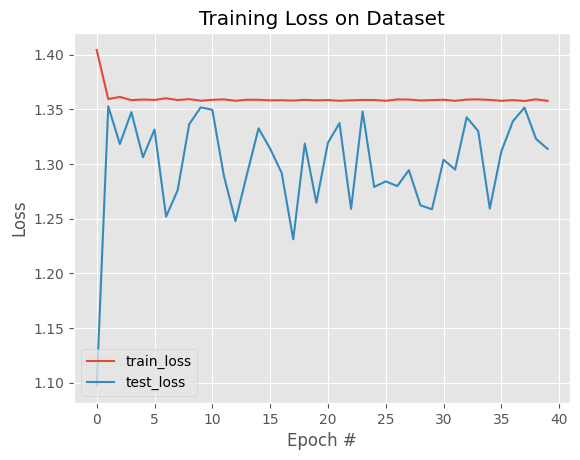

In [29]:
# initialize our UNet model
unet2 = UNet().to(configuration.device)

lossFunc = nn.CrossEntropyLoss()    # CrossEntropy as it is a multi class classificiation
opt = Adam(unet2.parameters(), lr=configuration.INIT_LR)


trainSteps = len(trainDS) // configuration.BATCH_SIZE
testSteps = len(testDS) // configuration.BATCH_SIZE
best_val_loss = float('inf')
best_epoch = 0
best_model_path = '/content/drive/MyDrive/MLProjectData/unet_best_model.pth'

H = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}


print("Training starts here for the network ...")
startTime = time.time()
for e in tqdm(range(configuration.NUM_EPOCHS)):

	unet2.train()


	totalTrainLoss = 0
	totalTestLoss = 0
	trainCorrect = 0
	trainTotal = 0
	testCorrect = 0
	testTotal = 0


	for (i, (x, y)) in enumerate(trainLoader):

		(x, y) = (x.to(configuration.device), y.to(configuration.device))

		pred = unet2(x)
		loss = lossFunc(pred, y.long())


		_, predictions = torch.max(pred, 1)
		trainCorrect += (predictions == y).sum().item()
		trainTotal += y.size(0)


		opt.zero_grad()
		loss.backward()
		opt.step()

		totalTrainLoss += loss

	trainAcc = trainCorrect / trainTotal
	H["train_acc"].append(trainAcc)

	with torch.no_grad():

		unet2.eval()

		for (x, y) in testLoader:
			(x, y) = (x.to(configuration.device), y.to(configuration.device))

			pred = unet2(x)
			totalTestLoss += lossFunc(pred, y)

			_, predictions = torch.max(pred, 1)
			testCorrect += (predictions == y).sum().item()
			testTotal += y.size(0)


	testAcc = testCorrect / testTotal
	H["test_acc"].append(testAcc)

	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps


	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())


	print("[INFO] EPOCH: {}/{}".format(e + 1, Configuration.NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))

	print(f"Train accuracy: {trainAcc:.4f}, Test accuracy: {testAcc:.4f}")

	avgTestLoss = totalTestLoss / testSteps
	if avgTestLoss < best_val_loss:
		print(f"New best model found at epoch {e+1} with test loss {avgTestLoss:.4f}")
		best_val_loss = avgTestLoss
		best_epoch = e + 1
		# best_model_save_path = os.path.join('/content/drive/MyDrive/MLProjectData', f'unet_best_model_epoch_{best_epoch}.pth')
		torch.save(unet2.state_dict(), best_model_path)


endTime = time.time()
print("Time taken to train the model: {:.2f}s".format(
	endTime - startTime))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")



In [ ]:
# Define the path to the saved model state
saved_model_state_path = '/content/drive/MyDrive/MLProjectData/unet_best_model.pth'

# Initialize your UNet model
unet2 = UNet().to(Configuration.device)

# Load the saved model state
unet2.load_state_dict(torch.load(saved_model_state_path))

# Make sure to switch to evaluation mode
unet2.eval()

In [30]:
def make_predictions(model, image_path, classLabels):
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (configuration.INPUT_IMAGE_WIDTH, configuration.INPUT_IMAGE_HEIGHT))
        image = image.astype("float32") / 255.0

        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(Configuration.device)

        # make the prediction and retrieve the index of the highest
        # score to find the predicted class label
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        predictedClass = preds.cpu().numpy()[0]

    # return the original image and the predicted class label
    return image, classLabels[predictedClass]


In [31]:
import pandas as pd

# Assuming `testImages` is a list of file paths in your test set
# and `classLabels` is a list or dict mapping class indices to class names

# Initialize a list to store image names and predicted class names
predictions = []

# Loop over the test images
for imagePath in kaggle_image_paths:
    # Extract the image file name
    imageFileName = imagePath.split(os.path.sep)[-1]

    # Make a prediction using the model
    _, predictedClass = make_predictions(unet2, imagePath, classes)

    # Store the result
    predictions.append([imageFileName, predictedClass])

# Convert the predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['ID', 'prediction'])

# Save the predictions to a CSV file
predictions_csv_path = '/content/drive/MyDrive/MLProjectData/predictions2.csv'
predictions_df.to_csv(predictions_csv_path, index=False)

print(f"Predictions saved to {predictions_csv_path}")


Predictions saved to /content/drive/MyDrive/MLProjectData/predictions2.csv
